In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [227]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
trip_calc = calc_temps('2017-08-01', '2017-08-07')


(72.0, 79.25, 83.0)

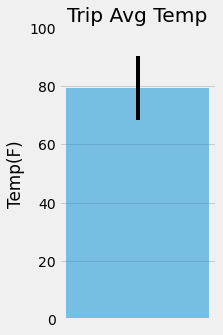

In [291]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title

# Use the average temperature for bar height (y value)
avg_trip_temp = [trip_calc[0][1]]

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min_trip_temp = trip_calc[0][0]
max_trip_temp = trip_calc[0][2]

error = [max_trip_temp - min_trip_temp]

#Create Bar Chart
fig, ax = plt.subplots(figsize=(2.5,5))
ax.bar(0, avg_trip_temp, yerr=error, width=.2, alpha=.5)
ax.set_ylabel('Temp(F)')
ax.set_xticklabels("")
ax.set_title('Trip Avg Temp')
ax.set_xticks([])
ax.set_ylim([0, 100])
plt.savefig('Output/trip_avg_temp.png')
plt.show()


### Daily Rainfall Average

In [157]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain_stations = session.query(measurement.station, station.name, station.latitude,\
                            station.longitude, func.sum(measurement.prcp))\
                            .filter(measurement.station==station.station)\
                            .filter(measurement.date.between('2016-08-01', '2016-08-07'))\
                            .group_by(measurement.station)\
                            .order_by(func.sum(measurement.prcp).desc()).statement

# Show query results
trip_rain = pd.read_sql_query(rain_stations,session.bind)
trip_rain

,station,name,latitude,longitude,sum_1
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,6.02
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,4.65
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,3.59
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,1.30
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,1.03
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,0.57
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,0.18


In [158]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [261]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
datelist = pd.date_range(start_date, end_date).tolist()
datestr = [str(x) for x in datelist]

# Strip off the year and save a list of strings in the format %m-%d
dates = [dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%m-%d') for x in datestr]

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
for x in dates:
    day_calcs = daily_normals(x)[0]
    normals.append(day_calcs)
    
normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [272]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_norms= pd.DataFrame(normals, columns=['tmin','tavg','tmax'])

trip_norms['date'] = dates
trip_norms.set_index('date')

,tmin,tavg,tmax
date,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


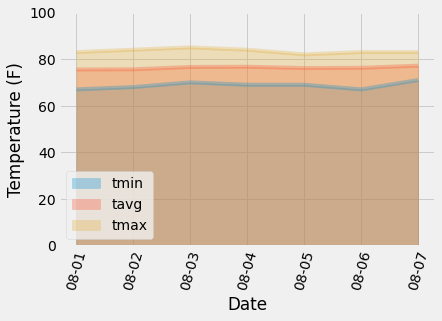

In [292]:
# Plot the daily normals as an area plot with `stacked=False`
trip_norms.plot.area(x='date', ylim=[0, 100], stacked=False, alpha=.3)
plt.ylabel('Temperature (F)')
plt.xlabel('Date')
plt.xticks(rotation=75)
plt.savefig('Output/trip_normals.png')
plt.show()

## Close Session

In [11]:
session.close()